In [2]:
! pip install langgraph langchain_core langchain-google-genai

In [10]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph,START,END,MessagesState
from langgraph.graph.state import CompiledStateGraph
from dotenv import load_dotenv
import os
from langchain_core.tools import tool
from langgraph.prebuilt import tools_condition,ToolNode
from langchain_core.messages import SystemMessage,HumanMessage
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image,display

load_dotenv()

google_api = os.getenv('GEMINI_API_KEY')
llm:ChatGoogleGenerativeAI = ChatGoogleGenerativeAI(model='gemini-1.5-flash',api_key=google_api)


In [12]:
def divide(a:int,b:int):
    ''' Divide a and b  
    Args:
    a: first int
    b:second int
    '''
    return a/b

def multiply(a:int,b:int):
    ''' Multiply a and b  
    Args:
    a: first int
    b:second int
    '''
    return a*b

def add(a:int,b:int):
    ''' Add a and b  
    Args:
    a: first int
    b:second int
    '''
    return a+b


tools: list[tool] = [add, multiply, divide]
llm_with_tools = llm.bind_tools(tools)

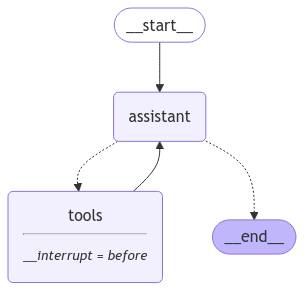

In [30]:
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

builder: StateGraph = StateGraph(MessagesState)

def assistant(state:MessagesState):
    return {'messages': [llm_with_tools.invoke([sys_msg] + state["messages"])]}    

builder.add_node('assistant',assistant)
builder.add_node('tools',ToolNode(tools))

builder.add_edge(START,'assistant')
builder.add_conditional_edges('assistant',tools_condition)

builder.add_edge('tools','assistant')

memory = MemorySaver()

graph : CompiledStateGraph = builder.compile(interrupt_before=['tools'],checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))

In [31]:
config = {'configurable' : {'thread_id' : '1'}}
message = HumanMessage('Multiply 2 and 3')
result = graph.stream({'messages':message},config, stream_mode='values')
for m in result:
    m['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (dd89e3a6-a0ab-422a-9267-0d7ba7b4b8eb)
 Call ID: dd89e3a6-a0ab-422a-9267-0d7ba7b4b8eb
  Args:
    a: 2.0
    b: 3.0


In [32]:
result = graph.stream(None,config, stream_mode='values')
for m in result:
    m['messages'][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  multiply (dd89e3a6-a0ab-422a-9267-0d7ba7b4b8eb)
 Call ID: dd89e3a6-a0ab-422a-9267-0d7ba7b4b8eb
  Args:
    a: 2.0
    b: 3.0
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The result is 6.
